# Day 3: Cross-Validation for Time Series
## Week 4: Machine Learning Foundations

---

**Learning Objectives:**
- Understand why standard CV fails for time series
- Implement walk-forward validation
- Use expanding and sliding windows
- Avoid look-ahead bias

In [7]:
# Day 3 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM']].dropna()
returns = prices.pct_change().dropna() * 100

print("=" * 60)
print("CROSS-VALIDATION FOR TIME SERIES - DAY 3")
print("=" * 60)

CROSS-VALIDATION FOR TIME SERIES - DAY 3


## 1. Why Standard K-Fold Fails

Standard K-Fold shuffles data, which:
- Uses future data to predict the past
- Creates **look-ahead bias**
- Gives overly optimistic performance

In [8]:
# Demonstrate the problem
print("=" * 60)
print("THE PROBLEM WITH K-FOLD FOR TIME SERIES")
print("=" * 60)

# Create lagged features
df_features = pd.DataFrame(index=returns.index)
df_features['target'] = returns['SPY']

# Lagged returns as features
for lag in range(1, 6):
    df_features[f'lag_{lag}'] = returns['SPY'].shift(lag)
    df_features[f'aapl_lag_{lag}'] = returns['AAPL'].shift(lag)

df_features = df_features.dropna()

X = df_features.drop('target', axis=1).values
y = df_features['target'].values

# Standard K-Fold (WRONG for time series)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
model = Ridge(alpha=1.0)

kfold_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

# Time Series Split (CORRECT)
tscv = TimeSeriesSplit(n_splits=5)
ts_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')

print(f"\nK-Fold CV (WRONG):")
print(f"  Mean R²: {kfold_scores.mean():.4f} ± {kfold_scores.std():.4f}")
print(f"  Scores:  {kfold_scores.round(4)}")

print(f"\nTime Series CV (CORRECT):")
print(f"  Mean R²: {ts_scores.mean():.4f} ± {ts_scores.std():.4f}")
print(f"  Scores:  {ts_scores.round(4)}")

print(f"\n⚠️ K-Fold gives OVERLY OPTIMISTIC results!")
print(f"   Difference: {(kfold_scores.mean() - ts_scores.mean()):.4f} R²")

THE PROBLEM WITH K-FOLD FOR TIME SERIES

K-Fold CV (WRONG):
  Mean R²: -0.0003 ± 0.0619
  Scores:  [ 0.0196  0.0492 -0.1225  0.0285  0.0238]

Time Series CV (CORRECT):
  Mean R²: -0.0957 ± 0.0877
  Scores:  [-0.2164 -0.1559 -0.052  -0.0941  0.0398]

⚠️ K-Fold gives OVERLY OPTIMISTIC results!
   Difference: 0.0954 R²


VISUALIZING CV SPLITS


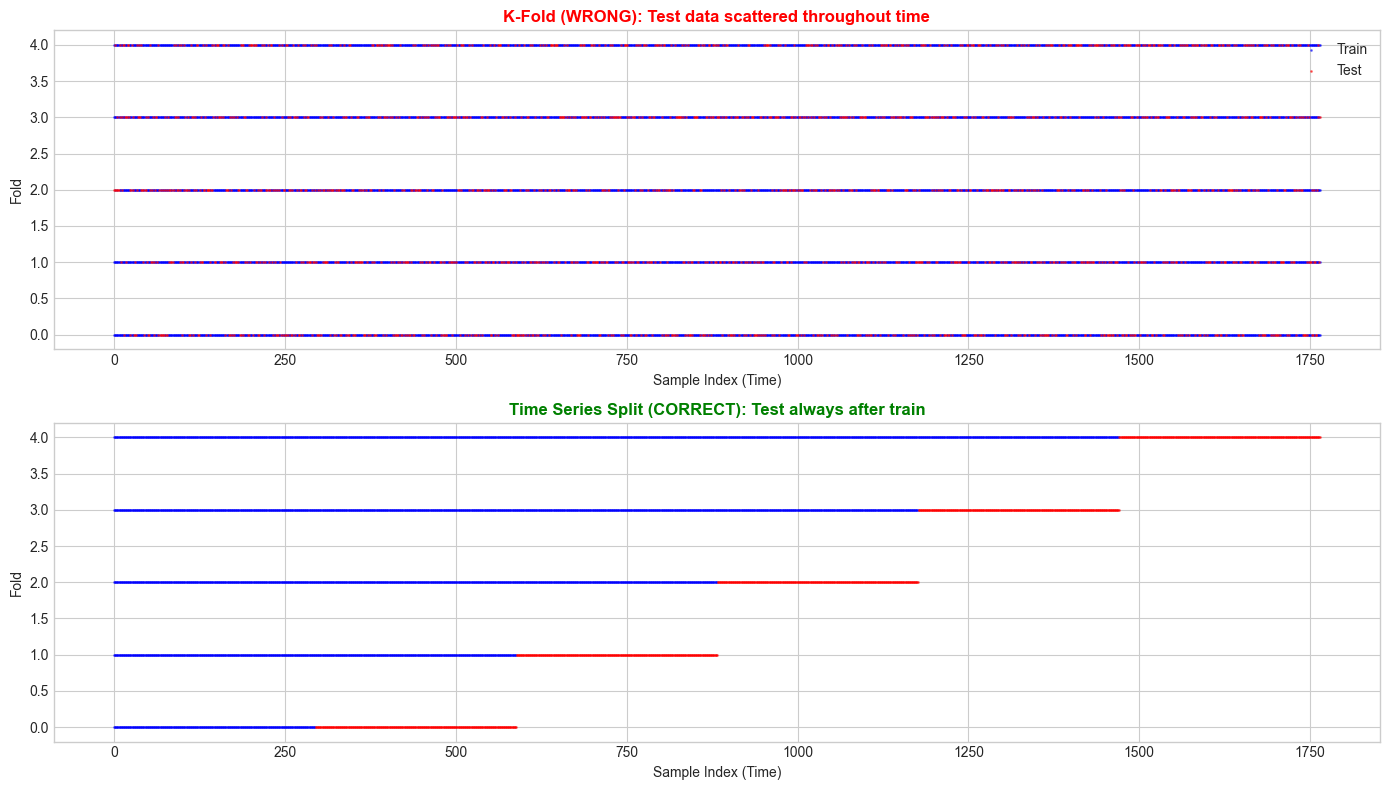

In [9]:
# Visualize the splits
print("=" * 60)
print("VISUALIZING CV SPLITS")
print("=" * 60)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

n = len(X)

# K-Fold (wrong)
ax = axes[0]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_idx, test_idx) in enumerate(kfold.split(X)):
    ax.scatter(train_idx, [i] * len(train_idx), c='blue', s=1, alpha=0.5)
    ax.scatter(test_idx, [i] * len(test_idx), c='red', s=1, alpha=0.5)

ax.set_xlabel('Sample Index (Time)')
ax.set_ylabel('Fold')
ax.set_title('K-Fold (WRONG): Test data scattered throughout time', fontweight='bold', color='red')
ax.legend(['Train', 'Test'], loc='upper right')

# Time Series Split (correct)
ax = axes[1]
tscv = TimeSeriesSplit(n_splits=5)
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    ax.scatter(train_idx, [i] * len(train_idx), c='blue', s=1, alpha=0.5)
    ax.scatter(test_idx, [i] * len(test_idx), c='red', s=1, alpha=0.5)

ax.set_xlabel('Sample Index (Time)')
ax.set_ylabel('Fold')
ax.set_title('Time Series Split (CORRECT): Test always after train', fontweight='bold', color='green')

plt.tight_layout()
plt.show()

## 2. Walk-Forward Validation

WALK-FORWARD VALIDATION

Walk-Forward Results (72 folds):
  Mean R²:   -0.1664
  Std R²:    0.4299
  Min R²:    -3.4991
  Max R²:    0.1616


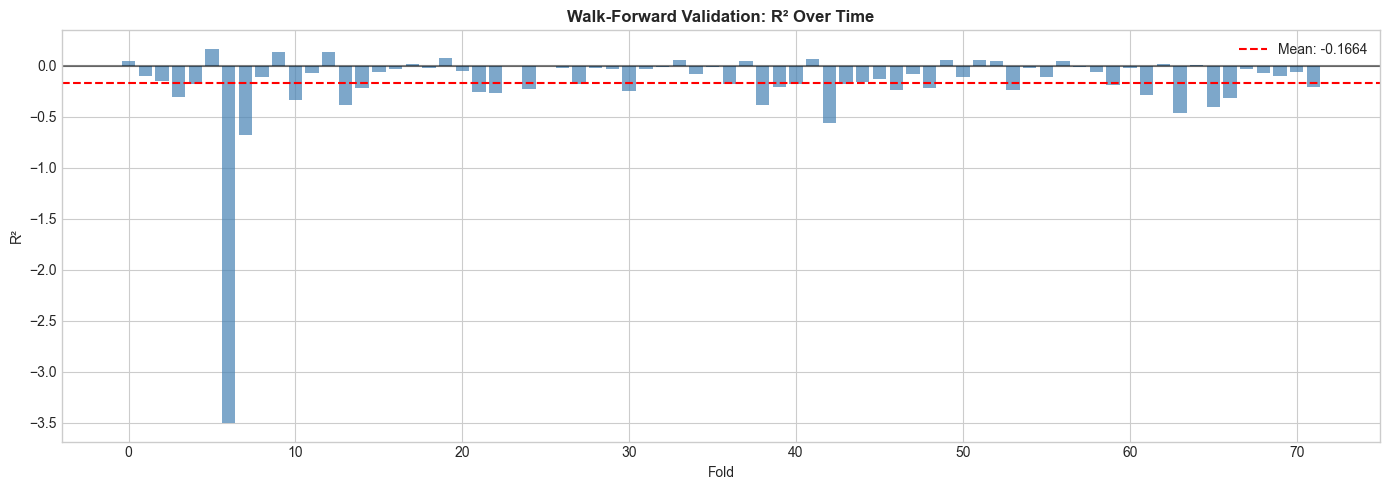

In [10]:
# Walk-forward validation
print("=" * 60)
print("WALK-FORWARD VALIDATION")
print("=" * 60)

def walk_forward_validation(X, y, model, train_size, test_size, step_size=None):
    """
    Walk-forward validation with expanding or sliding window.
    
    Parameters:
    - train_size: initial training window (or fixed for sliding)
    - test_size: how many periods to predict
    - step_size: how many periods to step forward (default = test_size)
    """
    if step_size is None:
        step_size = test_size
    
    n = len(X)
    results = []
    
    start = 0
    while start + train_size + test_size <= n:
        train_end = start + train_size
        test_end = train_end + test_size
        
        X_train = X[start:train_end]
        y_train = y[start:train_end]
        X_test = X[train_end:test_end]
        y_test = y[train_end:test_end]
        
        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'train_start': start,
            'train_end': train_end,
            'test_start': train_end,
            'test_end': test_end,
            'mse': mse,
            'r2': r2,
            'n_train': train_end - start,
            'n_test': test_size
        })
        
        start += step_size
    
    return pd.DataFrame(results)

# Apply walk-forward
model = Ridge(alpha=1.0)
wf_results = walk_forward_validation(X, y, model, 
                                     train_size=252,  # 1 year
                                     test_size=21,    # 1 month
                                     step_size=21)    # Step 1 month

print(f"\nWalk-Forward Results ({len(wf_results)} folds):")
print(f"  Mean R²:   {wf_results['r2'].mean():.4f}")
print(f"  Std R²:    {wf_results['r2'].std():.4f}")
print(f"  Min R²:    {wf_results['r2'].min():.4f}")
print(f"  Max R²:    {wf_results['r2'].max():.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(range(len(wf_results)), wf_results['r2'], color='steelblue', alpha=0.7)
ax.axhline(wf_results['r2'].mean(), color='red', linestyle='--', label=f"Mean: {wf_results['r2'].mean():.4f}")
ax.axhline(0, color='black', linestyle='-', alpha=0.5)
ax.set_xlabel('Fold')
ax.set_ylabel('R²')
ax.set_title('Walk-Forward Validation: R² Over Time', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Expanding vs Sliding Window

EXPANDING vs SLIDING WINDOW

Expanding Window:
  Mean R²: -0.1338 ± 0.2075

Sliding Window:
  Mean R²: -0.1664 ± 0.4299


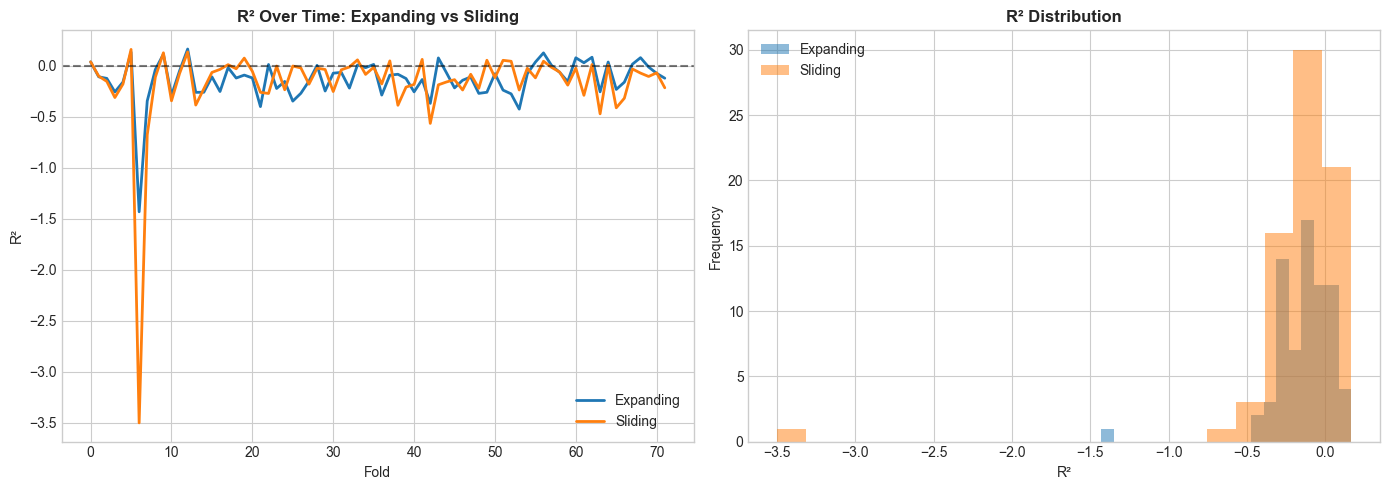


💡 Insights:
   Expanding: More data → more stable, but may include old patterns
   Sliding: Recent data only → adapts to regime changes


In [11]:
# Compare expanding vs sliding window
print("=" * 60)
print("EXPANDING vs SLIDING WINDOW")
print("=" * 60)

def expanding_window_cv(X, y, model, initial_train, test_size):
    """Expanding window: training set grows over time."""
    n = len(X)
    results = []
    
    train_end = initial_train
    while train_end + test_size <= n:
        X_train = X[:train_end]  # Expanding: always start from 0
        y_train = y[:train_end]
        X_test = X[train_end:train_end + test_size]
        y_test = y[train_end:train_end + test_size]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        results.append({'window': 'expanding', 'train_size': train_end, 'r2': r2})
        train_end += test_size
    
    return pd.DataFrame(results)

def sliding_window_cv(X, y, model, window_size, test_size):
    """Sliding window: fixed size training window."""
    n = len(X)
    results = []
    
    start = 0
    while start + window_size + test_size <= n:
        X_train = X[start:start + window_size]  # Fixed size
        y_train = y[start:start + window_size]
        X_test = X[start + window_size:start + window_size + test_size]
        y_test = y[start + window_size:start + window_size + test_size]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        results.append({'window': 'sliding', 'train_size': window_size, 'r2': r2})
        start += test_size
    
    return pd.DataFrame(results)

# Compare
model = Ridge(alpha=1.0)
expanding_results = expanding_window_cv(X, y, model, initial_train=252, test_size=21)
sliding_results = sliding_window_cv(X, y, model, window_size=252, test_size=21)

print(f"\nExpanding Window:")
print(f"  Mean R²: {expanding_results['r2'].mean():.4f} ± {expanding_results['r2'].std():.4f}")

print(f"\nSliding Window:")
print(f"  Mean R²: {sliding_results['r2'].mean():.4f} ± {sliding_results['r2'].std():.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² over time
axes[0].plot(expanding_results['r2'].values, label='Expanding', lw=2)
axes[0].plot(sliding_results['r2'].values, label='Sliding', lw=2)
axes[0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('R²')
axes[0].set_title('R² Over Time: Expanding vs Sliding', fontweight='bold')
axes[0].legend()

# Distribution
axes[1].hist(expanding_results['r2'], bins=20, alpha=0.5, label='Expanding')
axes[1].hist(sliding_results['r2'], bins=20, alpha=0.5, label='Sliding')
axes[1].set_xlabel('R²')
axes[1].set_ylabel('Frequency')
axes[1].set_title('R² Distribution', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n💡 Insights:")
print("   Expanding: More data → more stable, but may include old patterns")
print("   Sliding: Recent data only → adapts to regime changes")

## 4. Hyperparameter Tuning with Time Series CV

HYPERPARAMETER TUNING WITH TIME SERIES CV

Best alpha: 100
Best CV R²: -0.0604

 param_alpha  mean_train_score  mean_test_score  std_test_score
       0.001          0.076356        -0.096595        0.088803
       0.010          0.076356        -0.096587        0.088793
       0.100          0.076356        -0.096507        0.088693
       1.000          0.076355        -0.095713        0.087716
      10.000          0.076235        -0.088841        0.079796
     100.000          0.072882        -0.060434        0.058737


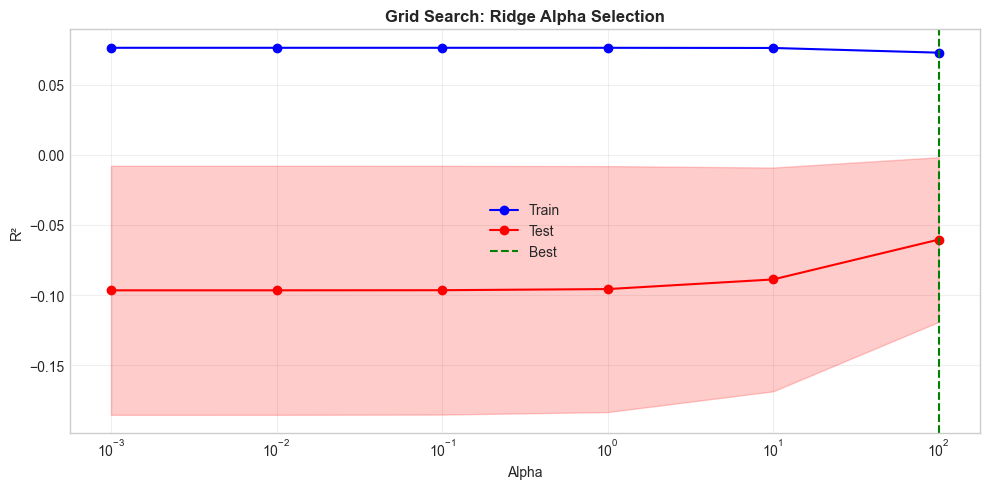

In [12]:
# Grid search with time series CV
print("=" * 60)
print("HYPERPARAMETER TUNING WITH TIME SERIES CV")
print("=" * 60)

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Time series CV
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
grid_search = GridSearchCV(
    Ridge(),
    param_grid,
    cv=tscv,
    scoring='r2',
    return_train_score=True
)

grid_search.fit(X, y)

# Results
print(f"\nBest alpha: {grid_search.best_params_['alpha']}")
print(f"Best CV R²: {grid_search.best_score_:.4f}")

# Detailed results
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha', 'mean_train_score', 'mean_test_score', 'std_test_score']]
print("\n" + results.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))

alphas = results['param_alpha'].values
ax.semilogx(alphas, results['mean_train_score'], 'b-o', label='Train')
ax.semilogx(alphas, results['mean_test_score'], 'r-o', label='Test')
ax.fill_between(alphas, 
                results['mean_test_score'] - results['std_test_score'],
                results['mean_test_score'] + results['std_test_score'],
                alpha=0.2, color='red')
ax.axvline(grid_search.best_params_['alpha'], color='green', linestyle='--', label='Best')
ax.set_xlabel('Alpha')
ax.set_ylabel('R²')
ax.set_title('Grid Search: Ridge Alpha Selection', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📝 Key Takeaways - Day 3

### Never Use Standard K-Fold for Time Series!
- Creates look-ahead bias
- Gives unrealistic performance estimates

### Time Series CV Methods:

| Method | Training Data | Pros | Cons |
|--------|---------------|------|------|
| Expanding | All past | More stable | May include old regimes |
| Sliding | Fixed window | Adapts to changes | Less data |
| Walk-Forward | Flexible | Realistic | Computationally heavy |

### Best Practices:
1. Always respect temporal order
2. Train on past, test on future
3. Use multiple test periods for robustness
4. Consider regime changes when choosing window size

### Interview Questions:
- "Why can't you use K-Fold for time series?"
- "Explain walk-forward validation"
- "When would you use expanding vs sliding window?"